This file includes:
* downsampling labels
* parsing the domains from urls
* transforming the dataset in tabular form
* stratification by year, primary, hard, making sure all texts from the same domain are in the same folder
* useful code for creating plots from the data

Data preparation for 60-20-20 split, optimizing stratification by genre and checking for the stratification of the rest.

In [16]:
import json

dataset_path = "/home/peterr/macocu/task5_webgenres/data/original/dataset/dataset.json"

with open(dataset_path, "r") as f:
    dataset = json.load(f)


In [17]:
len(dataset)

1002

# Downsampling rare labels

Rarely occuring primary and secondary labels will be changed as per `Dictionaries_for_genre_mapping.py`:

In [18]:
# First step - categories with less than 5 examples are merged with other categories:
first = {"Script/Drama":"Other", "Lyrical":"Other","FAQ":"Other"}

# Second step - categories (marked by the arrow in the hierarchy figure) are merged with similar categories:
# second = {"Recipe":"Instruction", "Research Article":"Information/Explanation", "Review":"Opinion/Argumentation", "Promotion of Services":"Promotion", "Promotion of a Product":"Promotion", "Invitation":"Promotion"}
second = dict()

In [19]:
change_counter = 0
for i, document in enumerate(dataset):
    primary = document["primary"]
    secondary = document["secondary"]

    if primary in first.keys():
        #print(f"Changing primary from {primary} to {first[primary]}")
        document["primary"] = first[primary]
        change_counter += 1
        
    if secondary in first.keys():
        #print(f"Changing secondary from {secondary} to {first[secondary]}")
        document["secondary"] = first[secondary]
        change_counter += 1

    if primary in second.keys():
        #print(f"Changing primary from {primary} to {second[primary]}")
        document["primary"] = second[primary]
        change_counter += 1

    if secondary in second.keys():
        #print(f"Changing secondary from {secondary} to {second[secondary]}")
        document["secondary"] = second[secondary]
        change_counter += 1

    dataset[i] = document
change_counter

8

In total 8 changes were made.

Next: domains will be extracted from urls and saved in the dataset.

In [20]:
import parse

pattern = "{protocol}://{domain}/{rest}"
p = parse.compile(pattern)

modified_pattern = "{protocol}://{domain}/"
mp = parse.compile(modified_pattern)
for document in dataset:
    parse_result = p.parse(document["url"])
    try:
        document["domain"] = parse_result["domain"]
    except TypeError:
        parse_result = mp.parse(document["url"])
        document["domain"] = parse_result["domain"]


# Transforming the dataset in tabular form

In [21]:
fields = dataset[0].keys()
fields

dict_keys(['id', 'url', 'crawled', 'primary', 'secondary', 'tertiary', 'hard', 'paragraphs', 'domain'])

In [22]:
tabular_dataset = dict()
for field in fields:
    tabular_dataset[field] = [item[field] for item in dataset]
tabular_dataset["stratum"] = [item["primary"] for item in dataset]

In [80]:
import pandas as pd

df = pd.DataFrame(data=tabular_dataset)
interim_dir = "/home/peterr/macocu/task5_webgenres/data/interim"
df.to_csv(interim_dir+"/tabular_1d.csv", index=False)


In [81]:
df.head()

,id,url,crawled,primary,secondary,tertiary,hard,paragraphs,domain,stratum
0,3949,http://www.pomurje.si/aktualno/sport/zimska-li...,2014,News/Reporting,,,False,"[{'text': 'Šport', 'duplicate': False, 'keep':...",www.pomurje.si,News/Reporting
1,3726,http://www.ss-sezana.si/sss/index.php?option=c...,2014,Information/Explanation,,,False,"[{'text': 'JEDILNIK', 'duplicate': False, 'kee...",www.ss-sezana.si,Information/Explanation
2,5621,http://www.kamnik-starejsi.si/novice/144-sodel...,2014,Promotion of Services,Opinion/Argumentation,Information/Explanation,False,"[{'text': 'Projekt INNOVAge in zavod Oreli', '...",www.kamnik-starejsi.si,Promotion of Services
3,3776,http://www.radiocelje.si/novica.php?id=13007&a...,2014,News/Reporting,,,False,"[{'text': 'V novembru, mesecu preprečevanja od...",www.radiocelje.si,News/Reporting
4,2102,http://www.mtv.si/novice/selena-gomez-ponudila...,2014,Opinionated News,,,False,[{'text': 'Selena Gomez ponudila v poslušanje ...,www.mtv.si,Opinionated News


In [82]:
ALL_LABELS = df.stratum.unique().tolist()
ALL_LABELS

['News/Reporting',
 'Information/Explanation',
 'Promotion of Services',
 'Opinionated News',
 'Promotion of a Product',
 'Invitation',
 'Legal/Regulation',
 'Forum',
 'Opinion/Argumentation',
 'Other',
 'Announcement',
 'Instruction',
 'Research Article',
 'List of Summaries/Excerpts',
 'Correspondence',
 'Promotion',
 'Recipe',
 'Review',
 'Prose',
 'Call',
 'Interview']

In [83]:
len(ALL_LABELS)

21

In [84]:
df["domain_unique"] = False
for domain in df.domain.unique():
    subset = df.loc[df.domain == domain,:]
    if len(subset) == 1:
        df.loc[df.domain == domain, "domain_unique"] = True

# Splitting:

My idea is to implement a greedy algorythm that loops through problematic labels, looks at which split 

+ ~~Split only the data with non problematic domains~~ Won't work due to underpopulated labels.
+ Loop through problematic labels, sorted by their count.
+ Check which split would benefit from moving this perticular domain bunch to it entirely
+ Add the domain bunch to the split that would benefit from it
+ repeat until no more problematic labels and the splits are approximately balanced. 

In [99]:
from sklearn.model_selection import train_test_split
import numpy as np

train, devtest = train_test_split(df, test_size=0.4, stratify=df.stratum)

In [100]:
bydomain = df.groupby("domain").count()["id"]
problematic_domains = bydomain[bydomain != 1].sort_values(ascending=False)


for i, domain in enumerate(problematic_domains.index):
    isindevtest = domain in devtest.stratum
    isintrain = domain in train.stratum

    if {isindevtest, isintrain} == {True, False}:
        continue
    train_size = train.shape[0]
    devtest_size = devtest.shape[0]
    domain_size = problematic_domains[domain]

    ideal_train_fraction = 0.6
    current_train_fraction = train_size / (train_size + devtest_size)

    if current_train_fraction >= ideal_train_fraction:
        # We will transfer instances from train to devtest

        transfer_indices = train.domain == domain
        devtest = pd.concat([devtest, train[transfer_indices]], ignore_index=True)
        train = train[~transfer_indices]
    else:
        # We will transfer instances from devtest to train

        transfer_indices = devtest.domain == domain
        train = pd.concat([train, devtest[transfer_indices]], ignore_index=True)
        devtest = devtest[~transfer_indices]
    
    devtest.reset_index(drop=True, inplace=True)
    train.reset_index(drop=True, inplace=True)

current_train_fraction

0.6017964071856288

In [101]:
train.primary.unique().shape[0], devtest.primary.unique().shape[0]

(21, 21)

In [102]:
for i, domain in enumerate(problematic_domains.index):
    if domain in train.domain.unique() and domain in devtest.domain.unique():
        print(f"Domain {domain} found in both!")

Notice how this produced no hits.

![Good, good](http://www.quickmeme.com/img/5e/5eff1c377f48790ca75a9a9878660481eeb4fde0172a2ad49505dc15890486c8.jpg)

Moving on, we still have to perform the same splitting on dev and test data:

In [115]:
dev, test = train_test_split(devtest, test_size=0.5, stratify=devtest.stratum)

In [116]:
bydomain = devtest.groupby("domain").count()["id"]
problematic_domains = bydomain[bydomain != 1].sort_values(ascending=False)
for i, domain in enumerate(problematic_domains.index):
    isindev = domain in dev.stratum
    isintest = domain in test.stratum

    if not isindev == isintest:
        continue
    dev_size = dev.shape[0]
    test_size = test.shape[0]
    domain_size = problematic_domains[domain]

    ideal_dev_fraction = 0.5
    current_dev_fraction = dev_size / (dev_size + test_size)

    if current_dev_fraction > ideal_dev_fraction:
        # We will transfer instances from dev to test

        transfer_indices = dev.domain == domain
        test = pd.concat([test, dev[transfer_indices]], ignore_index=True)
        dev = dev[~transfer_indices]
    else:
        # We will transfer instances from test to dev

        transfer_indices = test.domain == domain
        dev = pd.concat([dev, test[transfer_indices]], ignore_index=True)
        test = test[~transfer_indices]
    
    test.reset_index(drop=True, inplace=True)
    dev.reset_index(drop=True, inplace=True)

current_dev_fraction

0.4975

In [117]:
for split in [train, dev, test]:
    labelcount = split.primary.unique().shape[0]
    print(labelcount)
    if labelcount != 21:
        missing = set(ALL_LABELS) - set(split.primary.unique().tolist())
        print("We are missing ", missing)

        

21
21
21


In [113]:
pd.set_option('display.max_rows', None)
df[df.stratum.isin(["Recipe", "Research Article", "Prose"])].groupby("stratum,domain".split(",")).count()

id  url  crawled  primary  secondary  \
stratum          domain                                                        
Prose            locutio.si              2    2        2        2          2   
                 www.cvek.si             1    1        1        1          1   
                 www.pesem.si            1    1        1        1          1   
                 www.revija-vino.si      1    1        1        1          1   
                 www.saiorg.si           1    1        1        1          1   
Recipe           epsihologija.si         1    1        1        1          1   
                 jazkuham.si             2    2        2        2          2   
                 www.gg-steklarstvo.si   1    1        1        1          1   
                 www.mojmuffin.si        1    1        1        1          1   
                 zelisca-cvetka.si       1    1        1        1          1   
Research Article dk.um.si                2    2        2        2          2   
                 dkum.ukm.si             4    4        4        4          4   
                 dkum.uni-mb.si          1    1        1        1          1   
                 www.eurydice.si         1    1        1        1          1   
                 www.szd.si              1    1        1        1          1   

                                        tertiary  hard  paragraphs  \
stratum          domain                                              
Prose            locutio.si                    2     2           2   
                 www.cvek.si                   1     1           1   
                 www.pesem.si                  1     1           1   
                 www.revija-vino.si            1     1           1   
                 www.saiorg.si                 1     1           1   
Recipe           epsihologija.si               1     1           1   
                 jazkuham.si                   2     2           2   
                 www.gg-steklarstvo.si         1     1           1   
                 www.mojmuffin.si              1     1           1   
                 zelisca-cvetka.si             1     1           1   
Research Article dk.um.si                      2     2           2   
                 dkum.ukm.si                   4     4           4   
                 dkum.uni-mb.si                1     1           1   
                 www.eurydice.si               1     1           1   
                 www.szd.si                    1     1           1   

                                        domain_unique  
stratum          domain                                
Prose            locutio.si                         2  
                 www.cvek.si                        1  
                 www.pesem.si                       1  
                 www.revija-vino.si                 1  
                 www.saiorg.si                      1  
Recipe           epsihologija.si                    1  
                 jazkuham.si                        2  
                 www.gg-steklarstvo.si              1  
                 www.mojmuffin.si                   1  
                 zelisca-cvetka.si                  1  
Research Article dk.um.si                           2  
                 dkum.ukm.si                        4  
                 dkum.uni-mb.si                     1  
                 www.eurydice.si                    1  
                 www.szd.si                         1

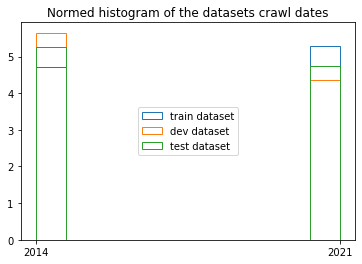

In [118]:
density = True
import matplotlib.pyplot as plt
plt.hist(train.crawled, label="train dataset", density=density, histtype="step")
plt.hist(dev.crawled, label="dev dataset", density=density, histtype="step")
plt.hist(test.crawled, label="test dataset", density=density, histtype="step")
plt.legend(loc="center")
plt.title("Normed histogram of the datasets crawl dates")
plt.savefig("images/1d_crawled.png")
plt.show()

In [119]:
bydomain = df.groupby("domain").count()["id"]
problematic_domains = bydomain[bydomain != 1]

for i, domain in enumerate(problematic_domains.index):
    is_in_train = domain in train.domain.unique()
    is_in_dev = domain in dev.domain.unique()
    is_in_test = domain in test.domain.unique()
    if sum([is_in_train, is_in_dev, is_in_test]) > 1:
        print(f"Domain {domain} found in: {'test ' if is_in_test else ''}{'train ' if is_in_train else ''}{'dev ' if is_in_dev else ''}")

In [120]:
import os

interim_dir = "/home/peterr/macocu/task5_webgenres/data/interim"

train.to_csv(os.path.join(interim_dir, "train_1d.csv"), index=False)
test.to_csv(os.path.join(interim_dir, "test_1d.csv"), index=False)
dev.to_csv(os.path.join(interim_dir, "dev_1d.csv"), index=False)

Let's check how the ratios of hardness and primary labels look like across the three splits:

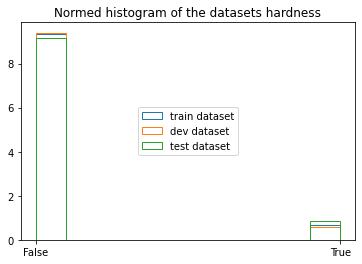

In [121]:
density = True

plt.hist(train.hard.apply(lambda b: str(b)), label="train dataset", density=density, histtype="step")
plt.hist(dev.hard.apply(lambda b: str(b)), label="dev dataset", density=density, histtype="step")
plt.hist(test.hard.apply(lambda b: str(b)), label="test dataset", density=density, histtype="step")
plt.legend(loc="center")
plt.title("Normed histogram of the datasets hardness")
plt.savefig("images/1d_hardness.png")
plt.show()

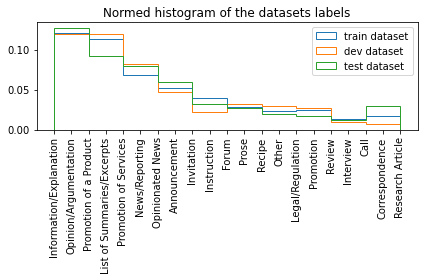

In [123]:
%matplotlib inline

density = True

plt.hist(train.primary, label="train dataset", density=density, histtype="step")
plt.hist(dev.primary, label="dev dataset", density=density, histtype="step")
plt.hist(test.primary, label="test dataset", density=density, histtype="step")
plt.legend()
plt.title("Normed histogram of the datasets labels")
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig("images/1d_primaries.png")
plt.show()